In [1]:
using ElectronPropagation
using PyPlot
using FFTW

smoothe(A, x, y, σ) = ifftshift(ifft(fft(A) .* fft(@. exp(-(x^2+y'^2)/σ^2))))
;

In [2]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 10
minval = 0.5
maxval = 1.0
cmap = get_cmap("PuOr")
violett = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
cmap = get_cmap("seismic")
red = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
norm = PyPlot.matplotlib.colors.Normalize(vmin=0, vmax=1)
;

In [3]:
U = 30e3

L = 50e-6
z = 0.5
w = 15e-6  # electron beam radius

λ = deBroglieWavelength(U)

# sampling
Δx = λ * z / L / 10

x = Vector{Float64}(range(-L/2, L/2-Δx, step=Δx))
y = copy(x)
;

## Derivation of the phase shift between the two peeks of $\Delta \varphi$
Phase shift from the laser pulse
$$
    \varphi = -\underbrace{\frac{\alpha}{2\pi (1 + \beta)} \frac{\lambda_L^2}{E_e}}_{K} \frac{E}{\int I \, dx dy} = -K \frac{E}{\int I \, dx dy} I
$$

Ansatz for the intensity distribution:
$$
    I = A \underbrace{f(x-x_1, y-y_1)}_{f_A} + B \underbrace{f(x-x_2, y-y_1)}_{f_B}
$$
with
$$
    \text{max} \, f = 1
$$
and the norm
$$
    N = \int_{-\infty}^\infty dx dy \, f(x, y) \text{.}
$$

Rewriting the phase shift gives
$$
    \varphi = -K \frac{E}{(A+B)N} \big( A f_A + B f_B \big) \text{.}
$$

The phase shift contribution of each peak gives
$$
    \varphi_A = -K \frac{E}{(A+B)N} A f_A \\
    \varphi_B = -K \frac{E}{(A+B)N} B f_B \text{,}
$$
which, under the assumption that $A=1$, that the maximum phase shift is wanted ($f_A=f_B=1$), that the phase difference between the maximum phase shifts is $\Delta \varphi$ and $\varphi_B = \varphi_A + \Delta \varphi$, can be rewritten to
$$
    \varphi_A = -K \frac{E}{(1+B)N} A \\
    \varphi_A = -K \frac{E}{(1+B)N} B - \Delta \varphi \text{.}
$$
Eliminating $\varphi_A$ and reshuffling everything gives
$$
    B = \frac{\displaystyle 1 - \frac{N \Delta \varphi}{KE}}{\displaystyle 1 + \frac{N \Delta \varphi}{KE}}
$$

In [4]:
c = 299792458           # the speed of light
ħ = 1.054571817e-34     # the reduced planck constant
m_e = 9.1093837015e-31  # the electron mass
q = 1.602176634e-19     # electron charge
ε_0 = 8.8541878128e-12  # vacuum permitivity

v = c * sqrt(1 - 1 / (1 + q*U/m_e/c^2)^2)
α = 1 / (4 * π * ε_0) * q^2 / (ħ * c)
β = v / c
γ = 1 / sqrt(1 - β^2)
Ee = γ*m_e*c^2
;

In [29]:
FWHM = 4.3e-6
wgauss = FWHM / 2.355
#wgauss = 10e-6
gauss_sep = 6e-6

# phase difference
Δφ = 2*π/1

Δimg = 0.02e-6

ximg = Vector{Float64}(range(-8e-6, 8e-6, step=Δimg))
yimg = Vector{Float64}(range(-16e-6, 16e-6, step=Δimg))

λ_l = 1035e-9
E = 60e-9

N = sum(@. exp(-(ximg^2 + yimg'^2)/wgauss^2)) * Δimg^2
K = α * λ_l^2 / (2 * π * (1 + β) * Ee)

B = (1 - N * Δφ / K / E) / (1 + N * Δφ / K / E)

I = @. (exp(-ximg^2/2/wgauss^2 - (yimg'-gauss_sep/2)^2/2/wgauss^2 )
        + B * exp(-ximg^2/2/wgauss^2 - (yimg'+gauss_sep/2)^2/2/wgauss^2 ) )

lb = LaserBeam(I, λ_l, E, ximg, yimg)

ψ = smoothe([i^2 + j^2 < w^2 ? complex(1.) : complex(0.) for i in x, j in y], x, y, 1e-6)
extent_e = [x[1], x[end], y[1], y[end]].*1e6

eb = ElectronBeam(ψ, U, x, y)
phase_imprint = PhaseImprint(lb)
free = Free(eb, z)
setup = Setup(phase_imprint, free)
propagation!(eb, setup)

out_int = abs2.(eb.ψ)
;

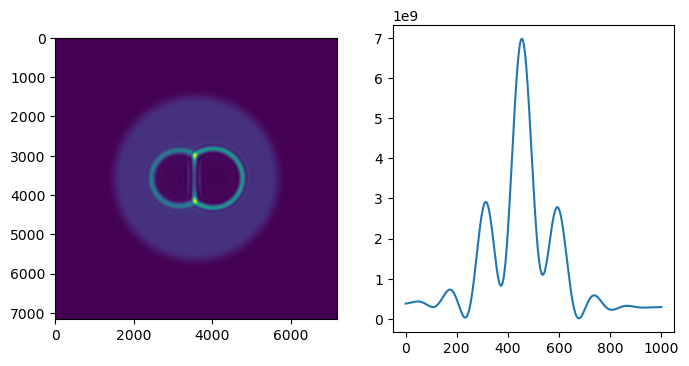

In [30]:
# plotting
cross = out_int[round(Int, size(out_int, 1)/2),
                round(Int, size(out_int, 2)/2)-500:round(Int, size(out_int, 2)/2)+500]

pygui(false)
figsize = [20, 10] / 2.504
fig, (ax1, ax2) = subplots(1, 2, figsize=figsize)
ax1.imshow(out_int)
ax2.plot(cross);

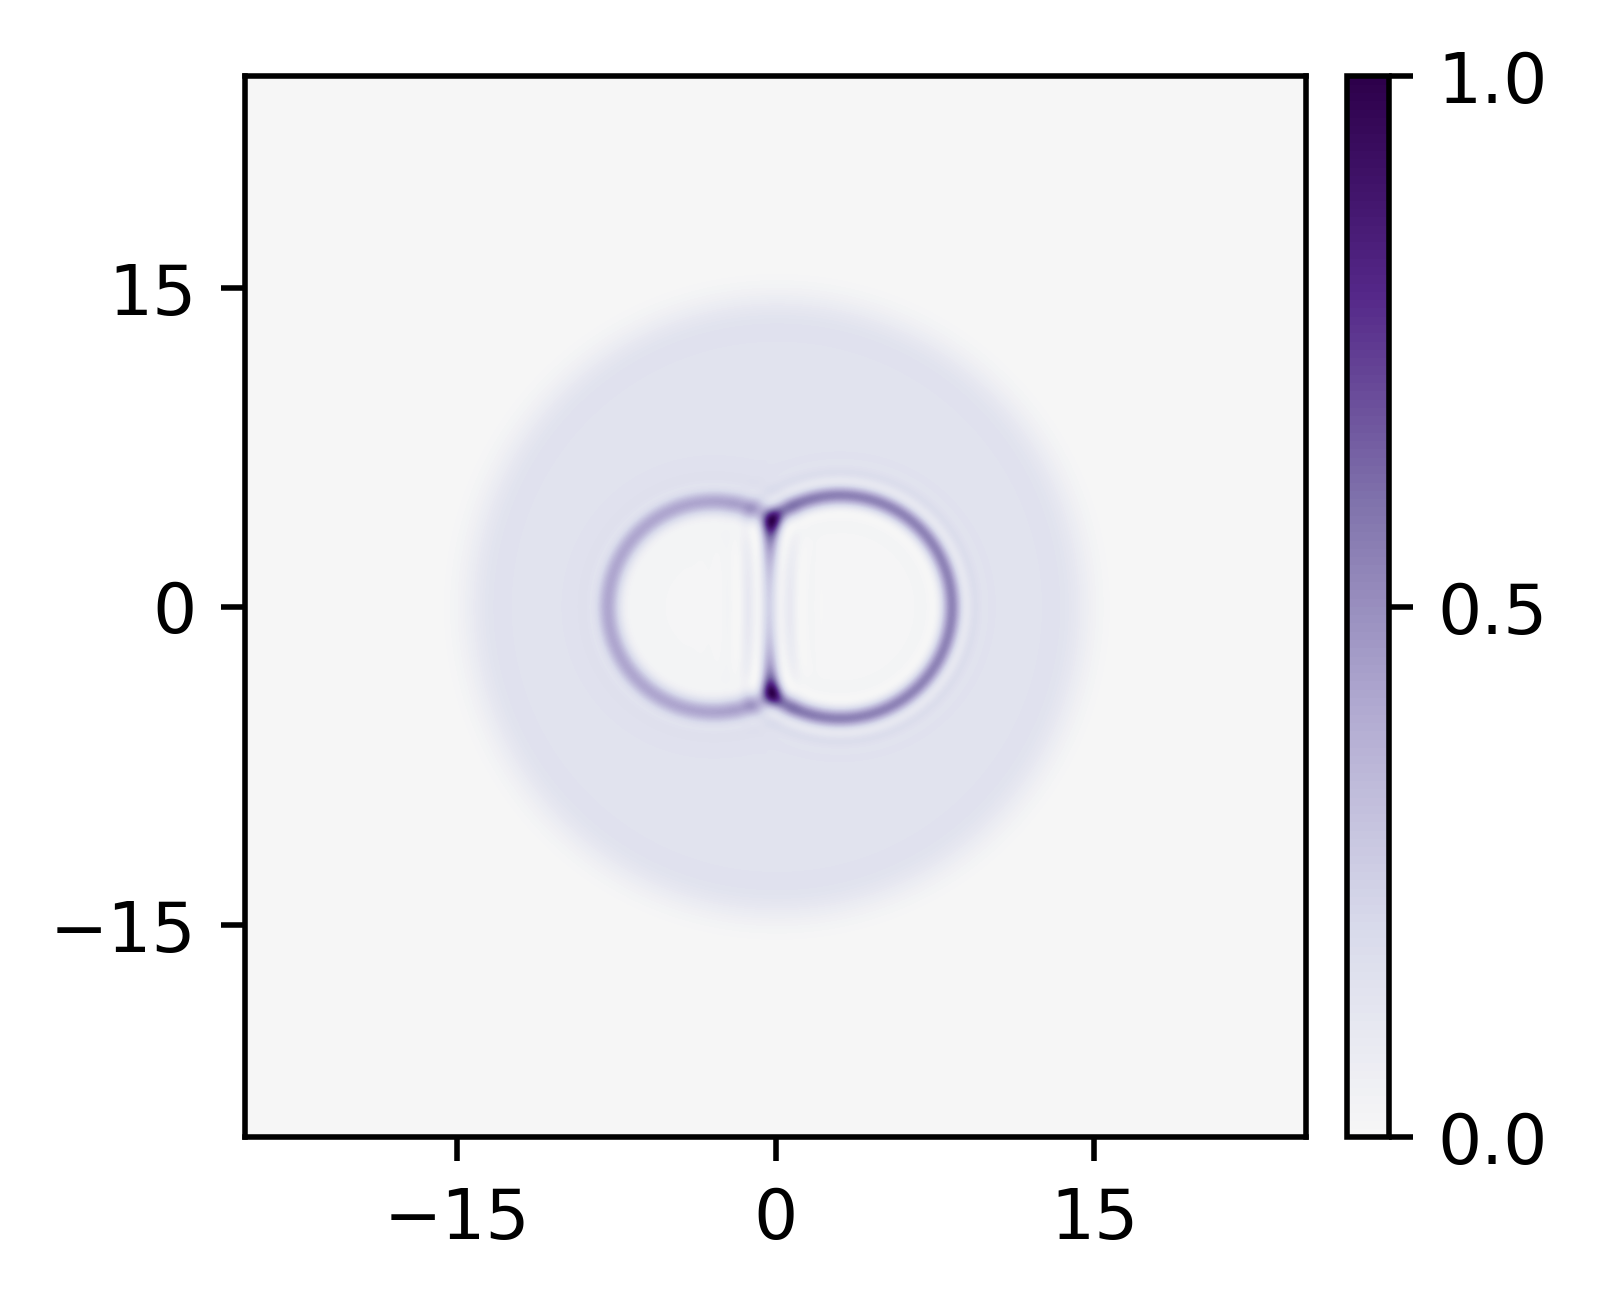

In [31]:
out = out_int ./ maximum(out_int)
out[1, 1] = 0

savestring = ("gauss"*string(round(Int, wgauss*1e6))
              *"sep"*string(round(Int, gauss_sep*1e6))
              *"dphi"*string(round(Int, Δφ))*"_picture.svg")

figsize = [7, 7] ./ 2.54

pygui(false)
fig, ax = subplots(figsize=figsize, dpi=500)
plt = ax.imshow(out, cmap=violett, extent=extent_e)

#ax.set_xlabel("µm")
#ax.set_ylabel("µm")

ax.set_xticks([-15, 0, 15])
ax.set_yticks([-15, 0, 15])

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)
savefig("./images/two_gauss_asym/"*savestring, bbox_inches="tight", dpi=500)
;

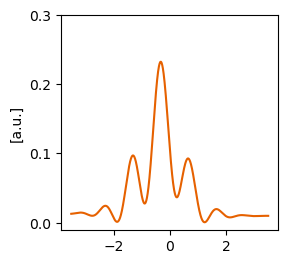

In [32]:
fov = 1000
cross = out[round(Int, size(out_int, 1)/2),
            round(Int, (size(out_int, 2)-fov)/2):round(Int, (size(out_int, 2)+fov)/2)]
xcross = x[round(Int, (size(out_int, 2)-fov)/2):round(Int, (size(out_int, 2)+fov)/2)] .* 1e6

savestring = ("gauss"*string(round(Int, wgauss*1e6))
              *"sep"*string(round(Int, gauss_sep*1e6))
              *"dphi"*string(round(Int, Δφ))*"_cross.svg")

figsize = [7, 7] ./ 2.504

pygui(false)
fig, ax = subplots(figsize=figsize)
ax.plot(xcross, cross, color="#E66100")

ax.set_yticks([0, 0.1, 0.2, 0.3])
ax.set_xticks([-2, 0, 2])

#ax.set_xlabel("µm")
ax.set_ylabel("[a.u.]")

savefig("./images/two_gauss_asym/"*savestring, bbox_inches="tight")
;

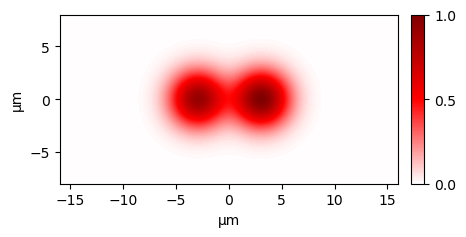

In [21]:
int_plot = I
int_plot[1, 1] = 0
int_plot ./= maximum(int_plot)

figsize = [11, 5.5] ./ 2.504
extent = [yimg[1], yimg[end], ximg[1], ximg[end]].*1e6

pygui(false)
fig, ax = subplots(figsize = figsize)
plt = ax.imshow(I, cmap=red, extent=extent)

ax.set_xlabel("µm")
ax.set_ylabel("µm")

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)

savefig("./images/two_gauss_asym/double_gaussian_intensity.svg", bbox_inches="tight", dpi=300)
;

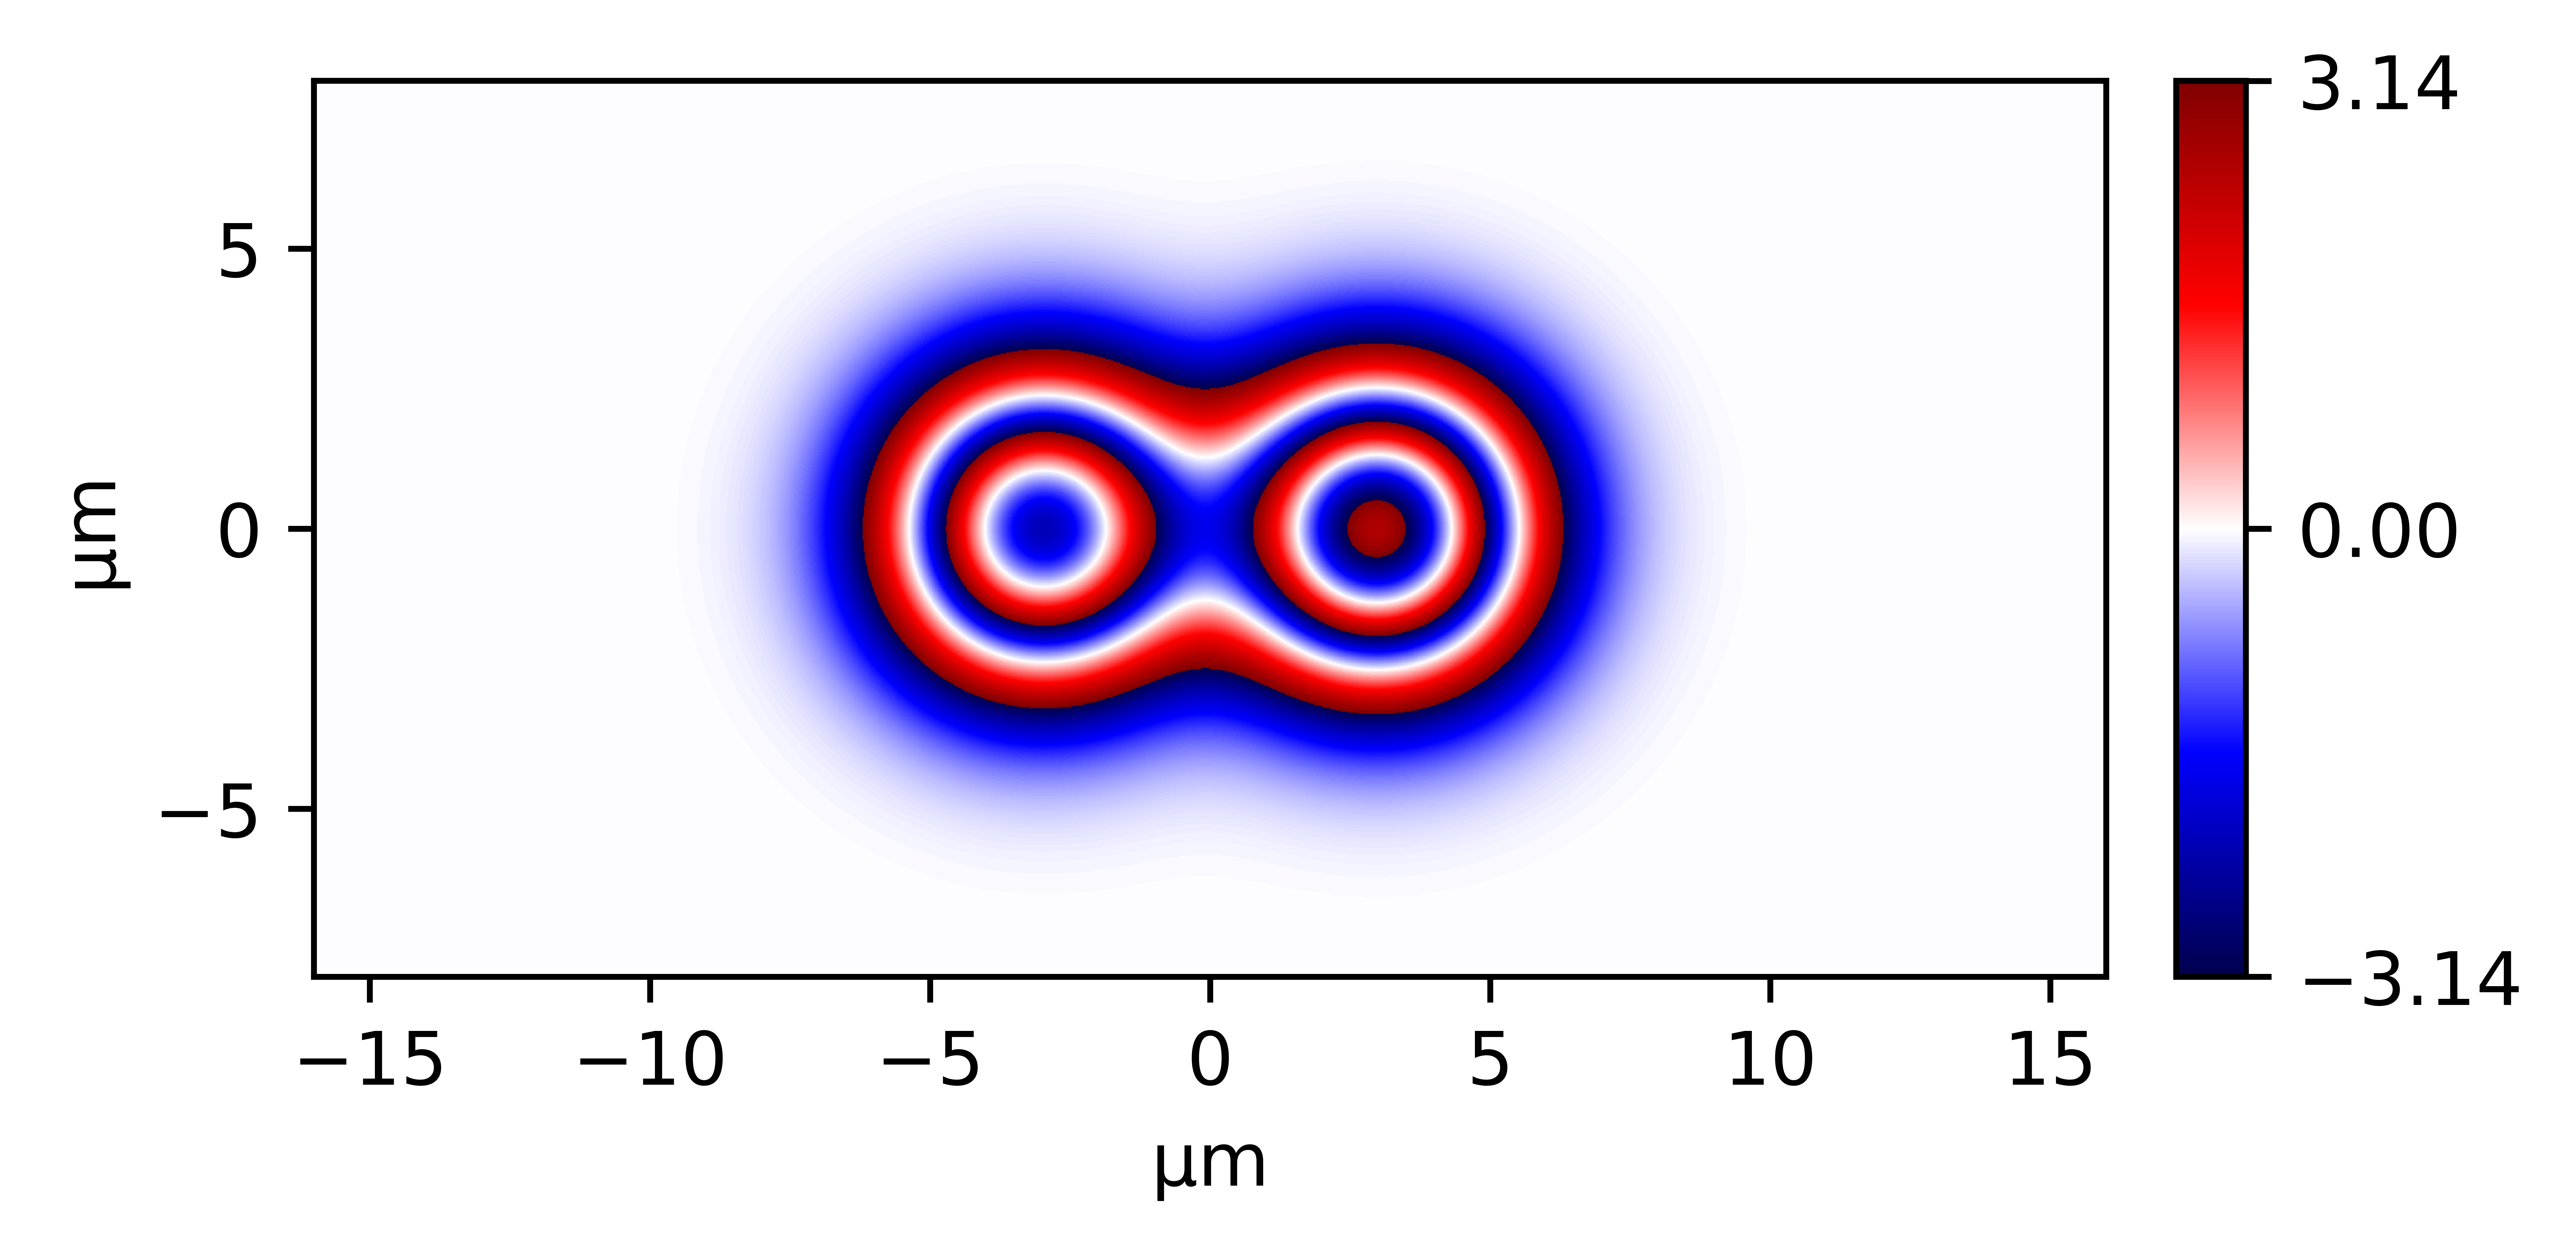

In [22]:
int_plot = I
int_plot[1, 1] = 0
int_plot ./= maximum(int_plot)

eb_plane = ElectronBeam(ones(ComplexF64, size(I)), U, ximg, yimg)
setup = Setup(PhaseImprint(lb))
propagation!(eb_plane, setup)

figsize = [11, 5.5] ./ 2.504
extent = [yimg[1], yimg[end], ximg[1], ximg[end]].*1e6

pygui(false)
fig, ax = subplots(figsize = figsize, dpi=2000)
plt = ax.imshow(angle.(eb_plane.ψ), cmap="seismic", extent=extent)

ax.set_xlabel("µm")
ax.set_ylabel("µm")

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[-3.14, 0, 3.14], cax=cax)

savefig("./images/two_gauss_asym/double_gaussian_phase.svg", bbox_inches="tight", dpi=2000)
;